# Mixing Layer 3D example
This is an example of using the mixing layer flow.
A three-dimensional flow is initialized and simulated. Afterward, the energy and the velocity field are plotted.

In [1]:
import lettuce as lt
import matplotlib.pyplot as plt
import numpy as np
import torch

## Setup
* for running on GPU: device = "cuda". CUDA drivers are required!
* dtype=torch.float32 for single precision - float64 for double precision
* select collision model (here BGKCollision) - try also KBCCollision or RegularizedCollision

### Code:
* Reporters will grab the results in between simulation steps (see reporters.py and simulation.py)
* Output: Column 1: simulation steps, Column 2: time in LU, Column 3: kinetic energy in PU
* Output: separate VTK-file with ux,uy,(uz) and p for every 100. time step in ./output

In [2]:
nmax     = 10000
nconsole = 200
nreport  = 100
# epsilon  = 0.001 # convergence condition: .1 % relative change
Re = 3200
res = 61
Ma = 0.5

lattice = lt.Lattice(lt.D3Q27, device = torch.device("cuda"), dtype=torch.float64, use_native=False)
flow = lt.MixingLayer3D(resolution=res, reynolds_number=Re, mach_number=Ma, lattice=lattice)
collision = lt.BGKCollision(lattice, tau=flow.units.relaxation_parameter_lu)
streaming = lt.StandardStreaming(lattice)
simulation = lt.Simulation(flow=flow, lattice=lattice, collision=collision, streaming=streaming)

Energy = lt.IncompressibleKineticEnergy(lattice, flow)
energy_reporter_internal = lt.ObservableReporter(Energy, interval=nreport, out=None)
simulation.reporters.append(energy_reporter_internal)
simulation.reporters.append(lt.ObservableReporter(Energy, interval=nconsole)) # print energy
simulation.reporters.append(lt.VTKReporter(lattice, flow, interval=nreport,
                                           filename_base="./data/mixinglayer3d" + "{:.1e}".format(Re) + "-res" + str(res) + "-Ma" + str(Ma) + "-symm-BGK/out"))

steps     time     IncompressibleKineticEnergy
steps     time     IncompressibleKineticEnergy


## Run simulations

In [3]:
simulation.initialize_f_neq()
mlups = simulation.step(nmax)
print("avg MLUPS: ", mlups)

# energy_new = 0
# mlups = 0
# iterations = int(nmax//nconsole)
# for _ in range(iterations):
#     energy_old = energy_new
#     energy_new = Energy(simulation.f).mean()
#     mlups += simulation.step(nconsole)
#     if abs((energy_new - energy_old)/energy_new) < epsilon:
#         print("CONVERGENCE! Less than ", epsilon*100, " % relative change")
#         break
#     if not energy_new == energy_new:
#         print("CRASH")
#         break
# print("avg MLUPS: ", mlups/iterations)

0 0.0 0.465277548714874


/home/philipp/lettuce/lettuce/simulation.py:122: UserWarning: where received a uint8 condition tensor. This behavior is deprecated and will be removed in a future version of PyTorch. Use a boolean condition instead. (Triggered internally at /opt/conda/conda-bld/pytorch_1678411187366/work/aten/src/ATen/native/TensorCompare.cpp:493.)
  self.f = torch.where(self.collision.no_collision_mask, self.f, self.collision(self.f))


200 0.9464758511305342 0.06471077738495695
400 1.8929517022610685 0.06890328445085261
600 2.8394275533916025 0.07240282019840037
800 3.785903404522137 0.07539414011431624
1000 4.732379255652671 0.07802780607249743
1200 5.678855106783205 0.08039987430992665
1400 6.625330957913739 0.08257203075026108
1600 7.571806809044274 0.08458156527356288
1800 8.518282660174808 0.08645384872680947
2000 9.464758511305343 0.08820874637578589
2200 10.411234362435877 0.08986321310119283
2400 11.35771021356641 0.09143255481567465
2600 12.304186064696944 0.092929369615817
2800 13.250661915827479 0.09436230897014457
3000 14.197137766958013 0.09573683071467497
3200 15.143613618088548 0.09705704041687302
3400 16.09008946921908 0.09832702261240021
3600 17.036565320349617 0.09955089238701621
3800 17.98304117148015 0.10073241736529356
4000 18.929517022610685 0.10187492693203998
4200 19.875992873741218 0.10298134719777259
4400 20.822468724871754 0.10405431195961129
4600 21.768944576002287 0.10509620395867975
4800

## Post process
### Energy Reporter
* Grab output of kinetic energy reporter

(101, 3)


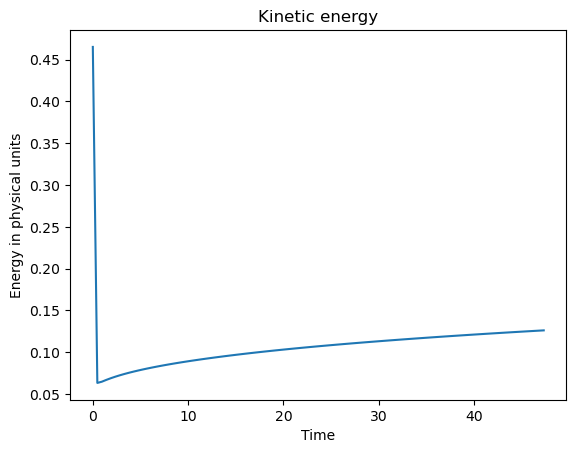

In [4]:
energy = np.array(simulation.reporters[0].out)
print(energy.shape)
plt.plot(energy[:,1],energy[:,2])
plt.title('Kinetic energy')
plt.xlabel('Time')
plt.ylabel('Energy in physical units')
plt.show()

### Velocity
We calculate the speed in Lettuce units depending on the last 'f'. Then we convert this velocity into physical units. For further investigations the tensor must be converted into a Numpy-Array. The norm of the fractions in x and y direction is plotted afterwards.

In [5]:
u_x, u_y = flow.units.convert_velocity_to_pu(lattice.u(simulation.f)).cpu().numpy()[:,:,int(res//2)]
x, y = flow.grid
plt.quiver(x.transpose(), y.transpose(), u_x.transpose(), u_y.transpose())

ValueError: too many values to unpack (expected 2)